### This notebook trains TotalVI shared only on shared features to see whether it is able to model both or not

In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)
import anndata as ad
import scanpy as sc
import torch
import random

In [2]:
def set_random_seed():
    # Example usage:
    seed = 42
    # Set seed for random module
    random.seed(seed)

    # Set seed for numpy
    np.random.seed(seed)

    # Set seed for torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_random_seed()

In [3]:
# read in protein data
protein = pd.read_csv("data/citeseq_pbmc/pro.csv") # 10k cells (protein)
# convert to AnnData
protein_adata = ad.AnnData(
    protein.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein.columns

# read in celltyle labels
metadata = pd.read_csv('data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

protein_adata.obs['celltype.l1'] = labels_l1
protein_adata.obs['celltype.l2'] = labels_l2

print("Final stats of protein adata: \n",protein_adata)

Final stats of protein adata: 
 AnnData object with n_obs × n_vars = 10000 × 224
    obs: 'celltype.l1', 'celltype.l2'


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [4]:
# read in RNA data
rna = mmread("./data/citeseq_pbmc/rna.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('./data/citeseq_pbmc/citeseq_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

# read in celltyle labels
metadata = pd.read_csv('./data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

rna_adata.obs['celltype.l1'] = labels_l1
rna_adata.obs['celltype.l2'] = labels_l2

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [5]:
rna_protein_correspondence = []
correspondence = pd.read_csv('data/protein_gene_conversion.csv')
for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)
print("Number of correspondence matches: ", rna_protein_correspondence.shape)
shared_gene_names_repeated = rna_protein_correspondence.T[0]
shared_protein_names_repeated = rna_protein_correspondence.T[1]
print("Unique shared gene names: {}, Unique shared protein names: {}".format(len(np.unique(shared_gene_names_repeated)), len(np.unique(shared_protein_names_repeated))))

Number of correspondence matches:  (180, 2)
Unique shared gene names: 170, Unique shared protein names: 170


In [6]:
shared_gene_features = list(set(shared_gene_names_repeated))
print("Final shared RNA: ",len(shared_gene_features))
shared_protein_features = list(set(shared_protein_names_repeated))
print("Final share protein: ", len(shared_protein_features))

rna_adata_copy = rna_adata.copy()
sc.pp.normalize_total(rna_adata_copy)
sc.pp.log1p(rna_adata_copy)
sc.pp.highly_variable_genes(rna_adata_copy, n_top_genes=2000)

highly_var_genes = list(set(rna_adata.var_names[rna_adata_copy.var.highly_variable==True]))
highly_var_genes_filtered = [gene for gene in highly_var_genes if gene not in shared_gene_features]

unshared_protein_features = [protein for protein in protein_adata.var_names if protein not in shared_protein_features]
print("Unshared protein features: ", len(unshared_protein_features))
print("variable genes that are not shared: ", len(highly_var_genes_filtered))

Final shared RNA:  170
Final share protein:  170
Unshared protein features:  54
variable genes that are not shared:  1911


In [7]:
def get_indices(feature_names, all_feature_names):
    """Returns the indices of features in 'feature_names' within the 'all_feature_names' list.

    Args:
        feature_names: A list of feature names to find indices for.
        all_feature_names: The complete list of all feature names.

    Returns:
        A list of indices corresponding to the positions of the 'feature_names' 
        within the 'all_feature_names' list. If a feature is not found, its index
        will be -1.
    """
    indices = []
    for feature in feature_names:
        try:
            index = all_feature_names.index(feature)
        except ValueError:
            index = -1  # Feature not found
        indices.append(index)
    return indices

In [8]:
unshared_gene_indices = get_indices(highly_var_genes_filtered, rna_adata.var_names.to_list())
shared_gene_indices = get_indices(shared_gene_names_repeated, rna_adata.var_names.to_list())
unshared_protein_indices = get_indices(unshared_protein_features, protein_adata.var_names.to_list())
shared_protein_indices = get_indices(shared_protein_names_repeated, protein_adata.var_names.to_list())

print("Length of unshared_gene_indices:", len(unshared_gene_indices))
print("Length of shared_gene_indices:", len(shared_gene_indices))
print("Length of unshared_protein_indices:", len(unshared_protein_indices))
print("Length of shared_protein_indices:", len(shared_protein_indices))

# Convert index lists to sets for unique element calculation
unshared_gene_unique = set(unshared_gene_indices)
shared_gene_unique = set(shared_gene_indices)
unshared_protein_unique = set(unshared_protein_indices)
shared_protein_unique = set(shared_protein_indices)

# Print lengths of unique elements
print("Unique elements in unshared_gene_indices:", len(unshared_gene_unique))
print("Unique elements in shared_gene_indices:", len(shared_gene_unique))
print("Unique elements in unshared_protein_indices:", len(unshared_protein_unique))
print("Unique elements in shared_protein_indices:", len(shared_protein_unique))

Length of unshared_gene_indices: 1911
Length of shared_gene_indices: 180
Length of unshared_protein_indices: 54
Length of shared_protein_indices: 180
Unique elements in unshared_gene_indices: 1911
Unique elements in shared_gene_indices: 170
Unique elements in unshared_protein_indices: 54
Unique elements in shared_protein_indices: 170


In [9]:
rna_unshared_adata = rna_adata[:,unshared_gene_indices]
rna_shared_adata = rna_adata[:,shared_gene_indices]
protein_unshared_adata = protein_adata[:,unshared_protein_indices]
protein_shared_adata = protein_adata[:,shared_protein_indices]

In [10]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class ProteinDataset(Dataset):
    def __init__(self,unshared_protein_adata, shared_protein_adata):
        self.unshared_data = np.asarray(unshared_protein_adata.X)
        self.shared_data = np.asarray(shared_protein_adata.X)
        self.labels_l1 = protein_adata.obs['celltype.l1']
        self.labels_l2 = protein_adata.obs['celltype.l2']
        
    def __len__(self):
        return self.unshared_data.shape[0]

    def __getitem__(self, idx):
        return {"y_unshared":self.unshared_data[idx], "y_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx]}

protein_dataset = ProteinDataset(protein_unshared_adata, protein_shared_adata)
protein_dataloader = DataLoader(protein_dataset, batch_size=256, shuffle=True)

In [11]:
class RNADataset(Dataset):
    def __init__(self,unshared_rna_adata, shared_rna_adata):
        self.unshared_data = np.asarray(unshared_rna_adata.X.todense())
        self.shared_data = np.asarray(shared_rna_adata.X.todense())
        self.labels_l1 = rna_adata.obs['celltype.l1']
        self.labels_l2 = rna_adata.obs['celltype.l2']
        self.local_mean, self.local_var = self.compute_library_size(np.concatenate([self.unshared_data, self.shared_data],axis=1))
        
    def __len__(self):
        return self.unshared_data.shape[0]

    def __getitem__(self, idx):
        return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean, "var": self.local_var}
    
    def compute_library_size(self, data):
        # print(data.shape)
        sum_counts = data.sum(axis=1)
        masked_log_sum = np.ma.log(sum_counts)
        if np.ma.is_masked(masked_log_sum):
            print(
                "Warning: This dataset has some empty cells, this might fail scVI inference. Data should be filtered with `my_dataset.filter_cells_by_count()"
            )
        log_counts = masked_log_sum.filled(0)
        local_mean = (np.mean(log_counts).reshape(-1, 1)).astype(np.float32)
        local_var = (np.var(log_counts).reshape(-1, 1)).astype(np.float32)

        local_mean = torch.Tensor(local_mean).reshape(-1)
        local_var = torch.Tensor(local_var).reshape(-1)
        return local_mean, local_var

rna_dataset = RNADataset(rna_unshared_adata, rna_shared_adata)
rna_dataloader = DataLoader(rna_dataset, batch_size=256, shuffle=True)

In [12]:
from scvi.models.proteinvi_unshared import PROTENVI_UNSHARED
from scvi.models.rna_unshared import RNA_UNSHARED
from scvi.models.totalvi_shared import TOTALVI_SHARED
import torch.nn.functional as F

# prodel = PROTENVI_UNSHARED(224, latent_distribution="normal", log_variational=True)
model = TOTALVI_SHARED(180, latent_distribution="normal", log_variational=True, reconstruction_loss_gene = "zinb")
# rodel = RNA_UNSHARED()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device used for training is: ", device)
model.to(device)
model_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(model_params, lr=0.001, eps=0.01)

The device used for training is:  cpu


Epoch: 0: 40it [00:01, 20.28it/s]


Losses at epoch: 0 is 3876.613426208496---------878.0985450744629--------3726.029640197754


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


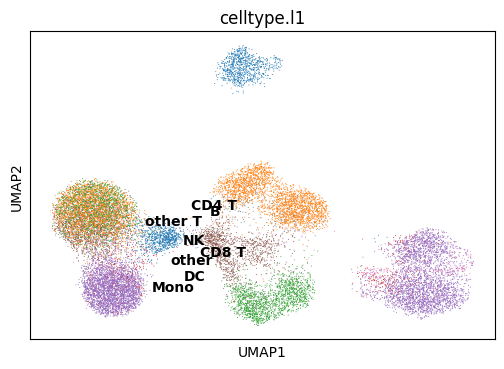

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


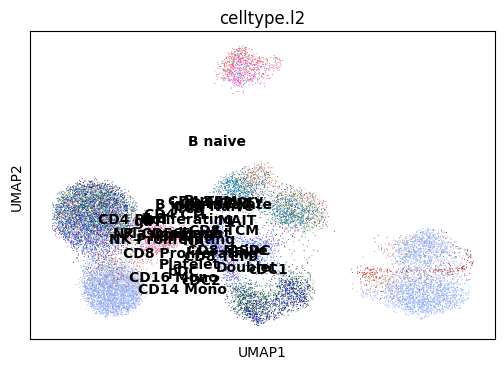

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


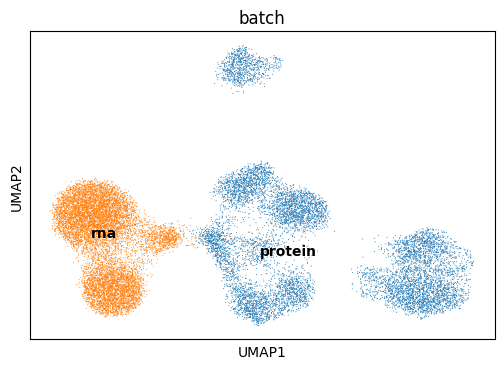

Epoch: 1: 40it [00:01, 20.24it/s]
Epoch: 2: 40it [00:01, 20.71it/s]
Epoch: 3: 40it [00:01, 20.15it/s]
Epoch: 4: 40it [00:01, 20.50it/s]
Epoch: 5: 40it [00:02, 18.73it/s]
Epoch: 6: 40it [00:02, 19.04it/s]
Epoch: 7: 40it [00:02, 19.77it/s]
Epoch: 8: 40it [00:02, 19.68it/s]
Epoch: 9: 40it [00:01, 20.30it/s]
Epoch: 10: 40it [00:02, 19.71it/s]
Epoch: 11: 40it [00:01, 20.35it/s]
Epoch: 12: 40it [00:02, 19.75it/s]
Epoch: 13: 40it [00:02, 19.74it/s]
Epoch: 14: 40it [00:02, 19.03it/s]
Epoch: 15: 40it [00:01, 20.35it/s]
Epoch: 16: 40it [00:02, 19.93it/s]
Epoch: 17: 40it [00:02, 19.79it/s]
Epoch: 18: 40it [00:01, 20.24it/s]
Epoch: 19: 40it [00:02, 20.00it/s]
Epoch: 20: 40it [00:02, 19.86it/s]


Losses at epoch: 20 is 3520.4087448120117---------559.3743762969971--------1362.8207397460938


Epoch: 21: 40it [00:02, 19.65it/s]
Epoch: 22: 40it [00:02, 18.49it/s]
Epoch: 23: 40it [00:02, 18.62it/s]
Epoch: 24: 40it [00:02, 18.21it/s]
Epoch: 25: 40it [00:02, 17.99it/s]
Epoch: 26: 40it [00:01, 20.19it/s]
Epoch: 27: 40it [00:02, 19.87it/s]
Epoch: 28: 40it [00:02, 19.78it/s]
Epoch: 29: 40it [00:02, 19.52it/s]
Epoch: 30: 40it [00:02, 19.95it/s]
Epoch: 31: 40it [00:01, 20.33it/s]
Epoch: 32: 40it [00:02, 19.85it/s]
Epoch: 33: 40it [00:02, 19.77it/s]
Epoch: 34: 40it [00:02, 19.28it/s]
Epoch: 35: 40it [00:02, 19.69it/s]
Epoch: 36: 40it [00:02, 19.62it/s]
Epoch: 37: 40it [00:02, 19.42it/s]
Epoch: 38: 40it [00:02, 19.61it/s]
Epoch: 39: 40it [00:02, 19.86it/s]
Epoch: 40: 40it [00:02, 19.36it/s]


Losses at epoch: 40 is 3390.380630493164---------506.89552307128906--------744.6704692840576


Epoch: 41: 40it [00:02, 19.67it/s]
Epoch: 42: 40it [00:02, 19.21it/s]
Epoch: 43: 40it [00:01, 20.36it/s]
Epoch: 44: 40it [00:02, 19.93it/s]
Epoch: 45: 40it [00:02, 19.74it/s]
Epoch: 46: 40it [00:02, 19.39it/s]
Epoch: 47: 40it [00:02, 18.90it/s]
Epoch: 48: 40it [00:02, 19.89it/s]
Epoch: 49: 40it [00:02, 16.34it/s]
Epoch: 50: 40it [00:02, 18.13it/s]
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


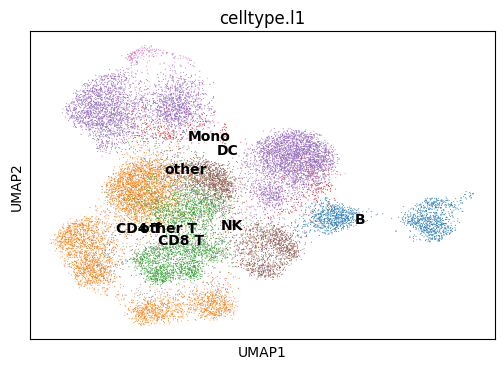

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


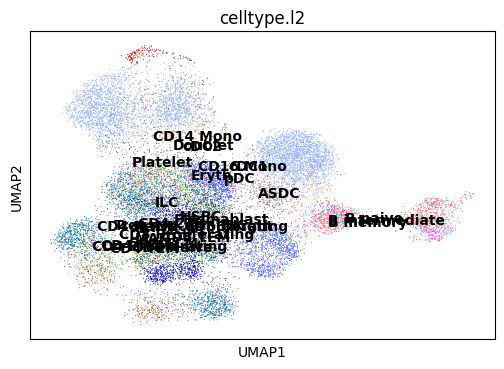

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


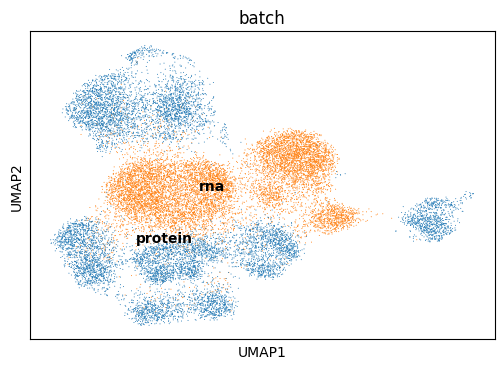

Epoch: 51: 40it [00:02, 19.91it/s]
Epoch: 52: 40it [00:02, 19.70it/s]
Epoch: 53: 40it [00:02, 18.78it/s]
Epoch: 54: 40it [00:02, 19.33it/s]
Epoch: 55: 40it [00:02, 18.29it/s]
Epoch: 56: 40it [00:02, 18.38it/s]
Epoch: 57: 40it [00:02, 19.30it/s]
Epoch: 58: 40it [00:02, 19.70it/s]
Epoch: 59: 40it [00:02, 19.22it/s]
Epoch: 60: 40it [00:02, 18.23it/s]


Losses at epoch: 60 is 3312.6138229370117---------499.245023727417--------458.2627201080322


Epoch: 61: 40it [00:02, 18.79it/s]
Epoch: 62: 40it [00:02, 19.60it/s]
Epoch: 63: 40it [00:02, 19.75it/s]
Epoch: 64: 40it [00:02, 19.26it/s]
Epoch: 65: 40it [00:02, 18.80it/s]
Epoch: 66: 40it [00:02, 19.26it/s]
Epoch: 67: 40it [00:02, 19.83it/s]
Epoch: 68: 40it [00:02, 19.30it/s]
Epoch: 69: 40it [00:02, 19.70it/s]
Epoch: 70: 40it [00:02, 19.39it/s]
Epoch: 71: 40it [00:02, 18.45it/s]
Epoch: 72: 40it [00:03, 12.86it/s]
Epoch: 73: 40it [00:02, 16.96it/s]
Epoch: 74: 40it [00:02, 18.89it/s]
Epoch: 75: 40it [00:02, 19.69it/s]
Epoch: 76: 40it [00:02, 19.07it/s]
Epoch: 77: 40it [00:02, 19.63it/s]
Epoch: 78: 40it [00:02, 19.13it/s]
Epoch: 79: 40it [00:02, 19.48it/s]
Epoch: 80: 40it [00:02, 19.44it/s]


Losses at epoch: 80 is 3272.448287963867---------515.6619157791138--------292.0750060081482


Epoch: 81: 40it [00:02, 19.60it/s]
Epoch: 82: 40it [00:02, 19.10it/s]
Epoch: 83: 40it [00:02, 19.21it/s]
Epoch: 84: 40it [00:01, 20.21it/s]
Epoch: 85: 40it [00:02, 18.38it/s]
Epoch: 86: 40it [00:02, 19.56it/s]
Epoch: 87: 40it [00:02, 18.86it/s]
Epoch: 88: 40it [00:02, 19.93it/s]
Epoch: 89: 40it [00:02, 19.37it/s]
Epoch: 90: 40it [00:02, 19.53it/s]
Epoch: 91: 40it [00:02, 19.89it/s]
Epoch: 92: 40it [00:02, 19.27it/s]
Epoch: 93: 40it [00:01, 20.06it/s]
Epoch: 94: 40it [00:02, 18.19it/s]
Epoch: 95: 40it [00:02, 19.67it/s]
Epoch: 96: 40it [00:02, 18.40it/s]
Epoch: 97: 40it [00:02, 19.81it/s]
Epoch: 98: 40it [00:02, 19.44it/s]
Epoch: 99: 40it [00:02, 19.06it/s]
Epoch: 100: 40it [00:02, 18.30it/s]


Losses at epoch: 100 is 3231.479591369629---------532.0067892074585--------190.76982879638672


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


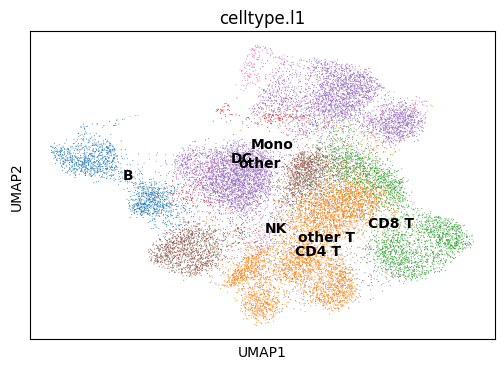

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


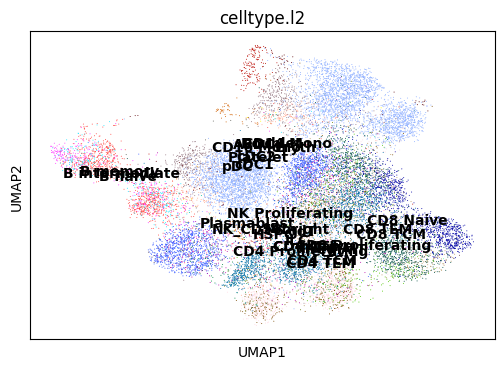

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


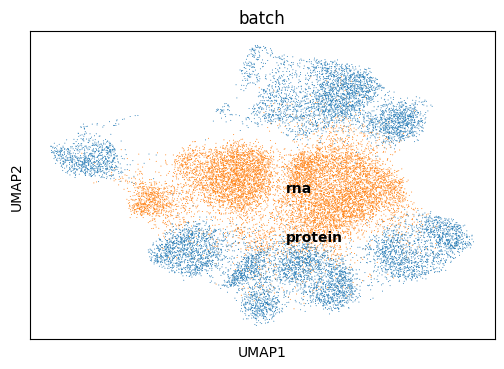

Epoch: 101: 40it [00:02, 17.96it/s]
Epoch: 102: 40it [00:02, 19.58it/s]
Epoch: 103: 40it [00:02, 18.51it/s]
Epoch: 104: 40it [00:02, 19.63it/s]
Epoch: 105: 40it [00:02, 16.48it/s]
Epoch: 106: 40it [00:02, 18.83it/s]
Epoch: 107: 40it [00:02, 17.97it/s]
Epoch: 108: 40it [00:02, 19.27it/s]
Epoch: 109: 40it [00:02, 19.08it/s]
Epoch: 110: 40it [00:02, 17.45it/s]
Epoch: 111: 40it [00:02, 19.52it/s]
Epoch: 112: 40it [00:02, 19.98it/s]
Epoch: 113: 40it [00:02, 19.34it/s]
Epoch: 114: 40it [00:01, 20.10it/s]
Epoch: 115: 40it [00:02, 18.30it/s]
Epoch: 116: 40it [00:01, 20.03it/s]
Epoch: 117: 40it [00:02, 18.44it/s]
Epoch: 118: 40it [00:02, 18.61it/s]
Epoch: 119: 40it [00:02, 19.53it/s]
Epoch: 120: 40it [00:02, 18.12it/s]


Losses at epoch: 120 is 3229.392936706543---------540.1647567749023--------146.92687964439392


Epoch: 121: 40it [00:02, 17.38it/s]
Epoch: 122: 40it [00:02, 18.88it/s]
Epoch: 123: 40it [00:02, 19.95it/s]
Epoch: 124: 40it [00:02, 19.38it/s]
Epoch: 125: 40it [00:02, 19.10it/s]
Epoch: 126: 40it [00:02, 19.11it/s]
Epoch: 127: 40it [00:01, 20.01it/s]
Epoch: 128: 40it [00:02, 19.89it/s]
Epoch: 129: 40it [00:02, 19.89it/s]
Epoch: 130: 40it [00:02, 17.80it/s]
Epoch: 131: 40it [00:02, 16.43it/s]
Epoch: 132: 40it [00:02, 14.29it/s]
Epoch: 133: 40it [00:01, 20.05it/s]
Epoch: 134: 40it [00:02, 19.40it/s]
Epoch: 135: 40it [00:02, 19.60it/s]
Epoch: 136: 40it [00:02, 19.05it/s]
Epoch: 137: 40it [00:02, 19.03it/s]
Epoch: 138: 40it [00:02, 19.75it/s]
Epoch: 139: 40it [00:02, 19.78it/s]
Epoch: 140: 40it [00:01, 20.19it/s]


Losses at epoch: 140 is 3194.9253692626953---------555.8873929977417--------148.29198253154755


Epoch: 141: 40it [00:02, 19.50it/s]
Epoch: 142: 40it [00:01, 20.28it/s]
Epoch: 143: 40it [00:02, 19.72it/s]
Epoch: 144: 40it [00:02, 19.86it/s]
Epoch: 145: 40it [00:02, 19.70it/s]
Epoch: 146: 40it [00:02, 19.62it/s]
Epoch: 147: 40it [00:01, 20.09it/s]
Epoch: 148: 40it [00:02, 19.52it/s]
Epoch: 149: 40it [00:02, 19.72it/s]
Epoch: 150: 40it [00:02, 19.63it/s]
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


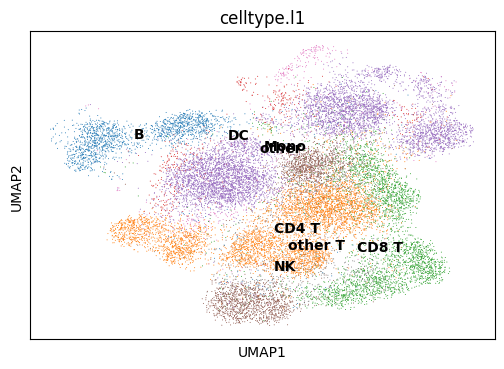

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


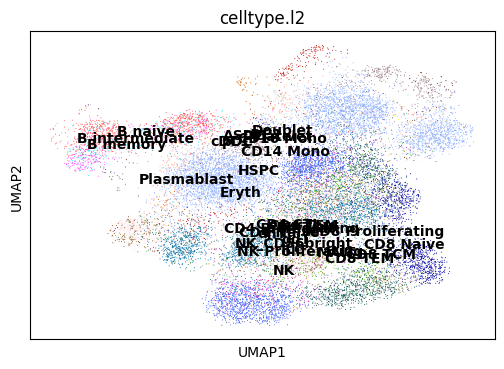

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


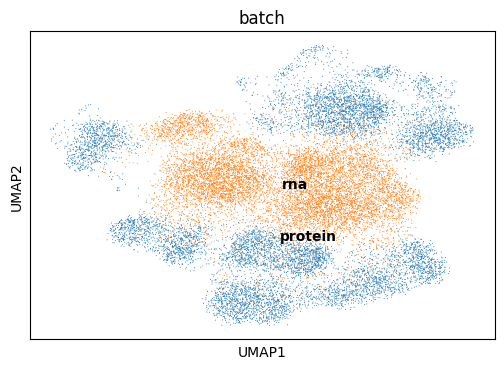

Epoch: 151: 40it [00:02, 19.95it/s]
Epoch: 152: 40it [00:01, 20.07it/s]
Epoch: 153: 40it [00:02, 19.69it/s]
Epoch: 154: 40it [00:01, 20.65it/s]
Epoch: 155: 40it [00:01, 20.62it/s]
Epoch: 156: 40it [00:02, 19.89it/s]
Epoch: 157: 40it [00:01, 20.51it/s]
Epoch: 158: 40it [00:01, 20.04it/s]
Epoch: 159: 40it [00:01, 20.49it/s]
Epoch: 160: 40it [00:02, 19.97it/s]


Losses at epoch: 160 is 3179.596351623535---------565.6279563903809--------128.95638990402222


Epoch: 161: 40it [00:01, 20.09it/s]
Epoch: 162: 40it [00:01, 20.01it/s]
Epoch: 163: 40it [00:01, 20.35it/s]
Epoch: 164: 40it [00:02, 19.80it/s]
Epoch: 165: 40it [00:01, 20.04it/s]
Epoch: 166: 40it [00:02, 19.20it/s]
Epoch: 167: 40it [00:02, 19.80it/s]
Epoch: 168: 40it [00:01, 20.14it/s]
Epoch: 169: 40it [00:01, 20.77it/s]
Epoch: 170: 40it [00:01, 20.20it/s]
Epoch: 171: 40it [00:01, 20.16it/s]
Epoch: 172: 40it [00:02, 19.64it/s]
Epoch: 173: 40it [00:01, 20.32it/s]
Epoch: 174: 40it [00:02, 19.64it/s]
Epoch: 175: 40it [00:01, 20.21it/s]
Epoch: 176: 40it [00:01, 20.22it/s]
Epoch: 177: 40it [00:02, 19.84it/s]
Epoch: 178: 40it [00:02, 19.92it/s]
Epoch: 179: 40it [00:01, 20.09it/s]
Epoch: 180: 40it [00:01, 20.48it/s]


Losses at epoch: 180 is 3173.1458587646484---------575.1306962966919--------158.9504108428955


Epoch: 181: 40it [00:02, 19.82it/s]
Epoch: 182: 40it [00:01, 20.09it/s]
Epoch: 183: 40it [00:02, 19.85it/s]
Epoch: 184: 40it [00:01, 20.11it/s]
Epoch: 185: 40it [00:01, 20.43it/s]
Epoch: 186: 40it [00:01, 20.06it/s]
Epoch: 187: 40it [00:02, 19.94it/s]
Epoch: 188: 40it [00:01, 20.71it/s]
Epoch: 189: 40it [00:02, 19.86it/s]
Epoch: 190: 40it [00:02, 19.89it/s]
Epoch: 191: 40it [00:01, 20.54it/s]
Epoch: 192: 40it [00:01, 20.04it/s]
Epoch: 193: 40it [00:02, 19.66it/s]
Epoch: 194: 40it [00:01, 20.35it/s]
Epoch: 195: 40it [00:02, 18.68it/s]
Epoch: 196: 40it [00:02, 19.65it/s]
Epoch: 197: 40it [00:02, 18.76it/s]
Epoch: 198: 40it [00:02, 19.10it/s]
Epoch: 199: 40it [00:02, 18.12it/s]
Epoch: 200: 40it [00:02, 18.83it/s]


Losses at epoch: 200 is 3155.7194900512695---------577.4726276397705--------88.40500295162201


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


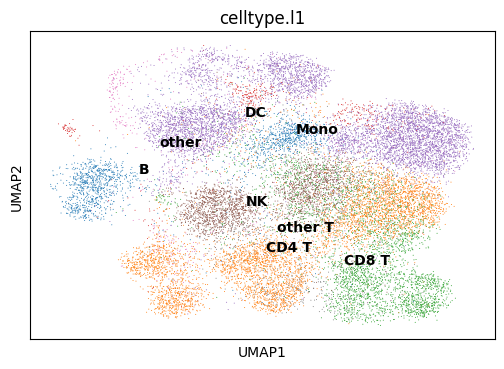

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


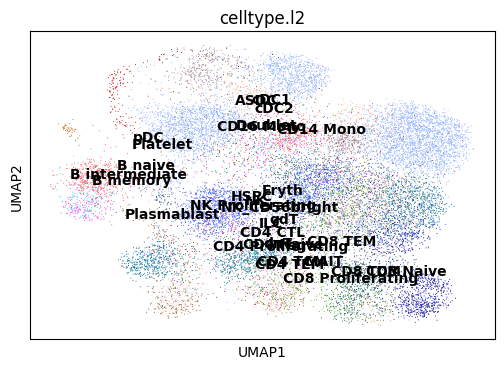

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


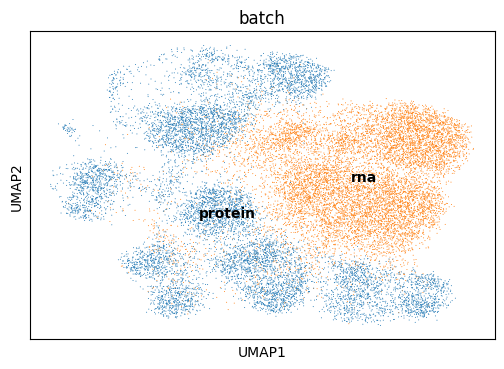

Epoch: 201: 40it [00:01, 20.22it/s]
Epoch: 202: 40it [00:02, 19.59it/s]
Epoch: 203: 40it [00:02, 18.96it/s]
Epoch: 204: 40it [00:02, 19.74it/s]
Epoch: 205: 40it [00:02, 19.25it/s]
Epoch: 206: 40it [00:02, 19.66it/s]
Epoch: 207: 40it [00:01, 20.24it/s]
Epoch: 208: 40it [00:01, 20.29it/s]
Epoch: 209: 40it [00:01, 20.19it/s]
Epoch: 210: 40it [00:01, 20.48it/s]
Epoch: 211: 40it [00:02, 19.73it/s]
Epoch: 212: 40it [00:02, 19.95it/s]
Epoch: 213: 40it [00:02, 19.74it/s]
Epoch: 214: 40it [00:01, 20.05it/s]
Epoch: 215: 40it [00:01, 20.04it/s]
Epoch: 216: 40it [00:02, 19.79it/s]
Epoch: 217: 40it [00:01, 20.10it/s]
Epoch: 218: 40it [00:01, 20.29it/s]
Epoch: 219: 40it [00:02, 19.27it/s]
Epoch: 220: 40it [00:01, 20.31it/s]


Losses at epoch: 220 is 3146.1883697509766---------581.7987012863159--------92.62350070476532


Epoch: 221: 40it [00:02, 19.93it/s]
Epoch: 222: 40it [00:01, 20.35it/s]
Epoch: 223: 40it [00:01, 20.24it/s]
Epoch: 224: 40it [00:01, 20.19it/s]
Epoch: 225: 40it [00:01, 20.64it/s]
Epoch: 226: 40it [00:01, 20.08it/s]
Epoch: 227: 40it [00:01, 20.70it/s]
Epoch: 228: 40it [00:01, 20.23it/s]
Epoch: 229: 40it [00:01, 20.25it/s]
Epoch: 230: 40it [00:01, 20.39it/s]
Epoch: 231: 40it [00:01, 21.08it/s]
Epoch: 232: 40it [00:01, 20.71it/s]
Epoch: 233: 40it [00:01, 20.11it/s]
Epoch: 234: 40it [00:01, 20.28it/s]
Epoch: 235: 40it [00:01, 20.21it/s]
Epoch: 236: 40it [00:01, 20.35it/s]
Epoch: 237: 40it [00:01, 20.51it/s]
Epoch: 238: 40it [00:02, 19.84it/s]
Epoch: 239: 40it [00:01, 20.47it/s]
Epoch: 240: 40it [00:01, 20.56it/s]


Losses at epoch: 240 is 3127.875801086426---------597.7665433883667--------101.09216904640198


Epoch: 241: 40it [00:01, 20.36it/s]
Epoch: 242: 40it [00:01, 20.30it/s]
Epoch: 243: 40it [00:01, 20.74it/s]
Epoch: 244: 40it [00:01, 20.60it/s]
Epoch: 245: 40it [00:01, 20.31it/s]
Epoch: 246: 40it [00:02, 19.17it/s]
Epoch: 247: 40it [00:01, 20.04it/s]
Epoch: 248: 40it [00:01, 20.39it/s]
Epoch: 249: 40it [00:02, 19.98it/s]
Epoch: 250: 40it [00:01, 20.07it/s]
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


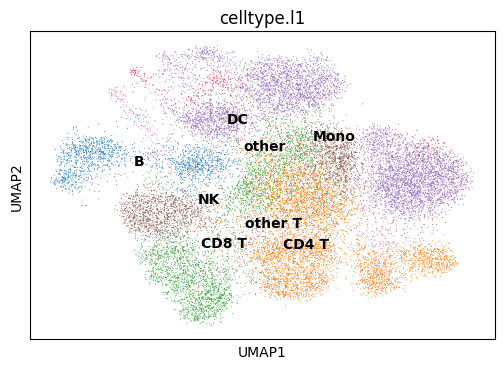

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


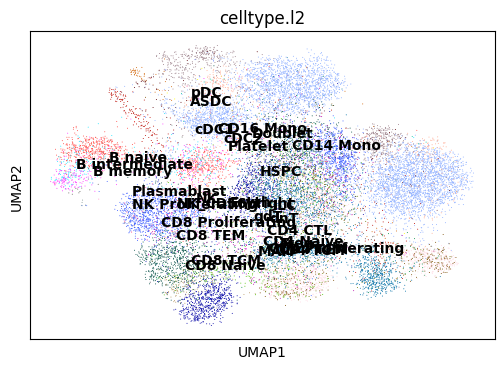

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


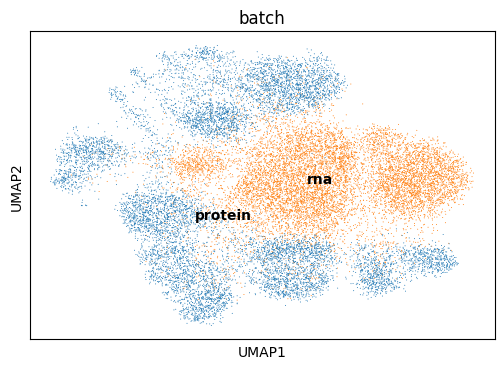

Epoch: 251: 40it [00:01, 20.24it/s]
Epoch: 252: 40it [00:01, 20.51it/s]
Epoch: 253: 40it [00:01, 20.45it/s]
Epoch: 254: 40it [00:02, 20.00it/s]
Epoch: 255: 40it [00:02, 19.54it/s]
Epoch: 256: 40it [00:02, 19.93it/s]
Epoch: 257: 40it [00:01, 20.59it/s]
Epoch: 258: 40it [00:01, 20.28it/s]
Epoch: 259: 40it [00:01, 20.39it/s]
Epoch: 260: 40it [00:01, 20.83it/s]


Losses at epoch: 260 is 3123.77140045166---------587.9241828918457--------83.77463525533676


Epoch: 261: 40it [00:02, 19.75it/s]
Epoch: 262: 40it [00:01, 20.53it/s]
Epoch: 263: 40it [00:02, 19.72it/s]
Epoch: 264: 40it [00:01, 20.09it/s]
Epoch: 265: 40it [00:01, 20.12it/s]
Epoch: 266: 40it [00:01, 20.43it/s]
Epoch: 267: 40it [00:01, 20.79it/s]
Epoch: 268: 40it [00:01, 20.35it/s]
Epoch: 269: 40it [00:01, 20.10it/s]
Epoch: 270: 40it [00:01, 20.09it/s]
Epoch: 271: 40it [00:02, 17.80it/s]
Epoch: 272: 40it [00:02, 17.98it/s]
Epoch: 273: 40it [00:02, 18.42it/s]
Epoch: 274: 40it [00:02, 18.64it/s]
Epoch: 275: 40it [00:02, 18.30it/s]
Epoch: 276: 40it [00:02, 19.54it/s]
Epoch: 277: 40it [00:01, 20.10it/s]
Epoch: 278: 40it [00:02, 19.60it/s]
Epoch: 279: 40it [00:02, 19.79it/s]
Epoch: 280: 40it [00:01, 20.11it/s]


Losses at epoch: 280 is 3120.8163452148438---------597.7586860656738--------73.09276300668716


Epoch: 281: 40it [00:02, 19.46it/s]
Epoch: 282: 40it [00:01, 20.44it/s]
Epoch: 283: 40it [00:02, 19.83it/s]
Epoch: 284: 40it [00:01, 20.04it/s]
Epoch: 285: 40it [00:01, 20.11it/s]
Epoch: 286: 40it [00:02, 19.95it/s]
Epoch: 287: 40it [00:02, 19.81it/s]
Epoch: 288: 40it [00:01, 20.02it/s]
Epoch: 289: 40it [00:02, 18.22it/s]
Epoch: 290: 40it [00:02, 17.91it/s]
Epoch: 291: 40it [00:01, 20.29it/s]
Epoch: 292: 40it [00:02, 18.98it/s]
Epoch: 293: 40it [00:02, 19.17it/s]
Epoch: 294: 40it [00:02, 19.57it/s]
Epoch: 295: 40it [00:01, 20.59it/s]
Epoch: 296: 40it [00:01, 20.36it/s]
Epoch: 297: 40it [00:01, 20.41it/s]
Epoch: 298: 40it [00:01, 20.35it/s]
Epoch: 299: 40it [00:01, 20.03it/s]
Epoch: 300: 40it [00:01, 20.27it/s]


Losses at epoch: 300 is 3116.484550476074---------605.98362159729--------92.80342257022858


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


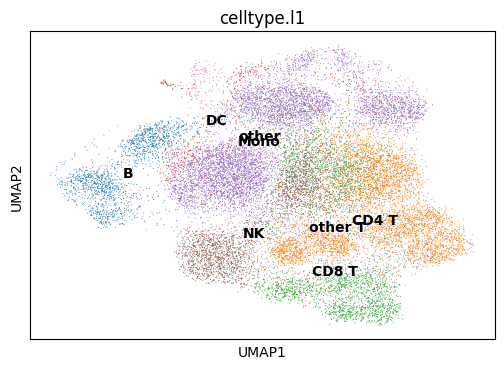

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


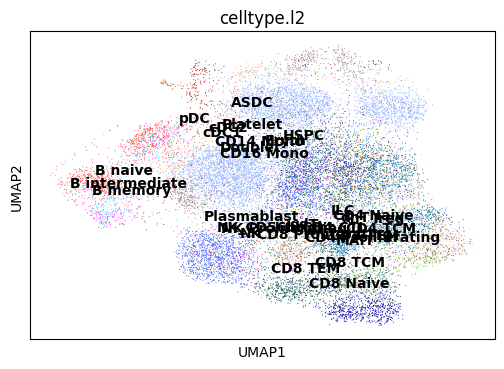

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


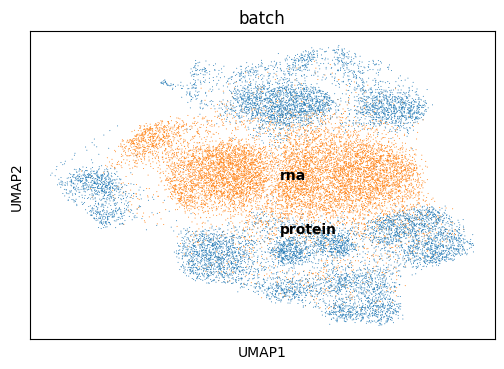

Epoch: 301: 40it [00:01, 20.59it/s]
Epoch: 302: 40it [00:01, 21.40it/s]
Epoch: 303: 40it [00:01, 21.58it/s]
Epoch: 304: 40it [00:01, 20.60it/s]
Epoch: 305: 40it [00:01, 20.96it/s]
Epoch: 306: 40it [00:01, 20.23it/s]
Epoch: 307: 40it [00:01, 20.97it/s]
Epoch: 308: 40it [00:01, 20.89it/s]
Epoch: 309: 40it [00:01, 20.46it/s]
Epoch: 310: 40it [00:01, 21.08it/s]
Epoch: 311: 40it [00:01, 20.47it/s]
Epoch: 312: 40it [00:01, 20.88it/s]
Epoch: 313: 40it [00:01, 20.76it/s]
Epoch: 314: 40it [00:01, 20.22it/s]
Epoch: 315: 40it [00:01, 21.05it/s]
Epoch: 316: 40it [00:02, 19.33it/s]
Epoch: 317: 40it [00:01, 20.65it/s]
Epoch: 318: 40it [00:01, 20.49it/s]
Epoch: 319: 40it [00:01, 20.22it/s]
Epoch: 320: 40it [00:01, 20.54it/s]


Losses at epoch: 320 is 3105.1133346557617---------599.2910394668579--------63.68890118598938


Epoch: 321: 40it [00:01, 20.44it/s]
Epoch: 322: 40it [00:01, 20.77it/s]
Epoch: 323: 40it [00:01, 20.74it/s]
Epoch: 324: 40it [00:01, 20.08it/s]
Epoch: 325: 40it [00:02, 19.94it/s]
Epoch: 326: 40it [00:01, 20.24it/s]
Epoch: 327: 40it [00:01, 21.13it/s]
Epoch: 328: 40it [00:01, 20.84it/s]
Epoch: 329: 40it [00:01, 20.32it/s]
Epoch: 330: 40it [00:01, 20.89it/s]
Epoch: 331: 40it [00:01, 20.78it/s]
Epoch: 332: 40it [00:01, 20.31it/s]
Epoch: 333: 40it [00:01, 20.81it/s]
Epoch: 334: 40it [00:01, 20.49it/s]
Epoch: 335: 40it [00:01, 20.57it/s]
Epoch: 336: 40it [00:01, 20.67it/s]
Epoch: 337: 40it [00:01, 20.48it/s]
Epoch: 338: 40it [00:01, 20.94it/s]
Epoch: 339: 40it [00:01, 20.46it/s]
Epoch: 340: 40it [00:01, 20.42it/s]


Losses at epoch: 340 is 3089.0614471435547---------598.7365436553955--------48.818464040756226


Epoch: 341: 40it [00:01, 20.85it/s]
Epoch: 342: 40it [00:01, 20.41it/s]
Epoch: 343: 40it [00:01, 21.38it/s]
Epoch: 344: 40it [00:01, 20.46it/s]
Epoch: 345: 40it [00:01, 20.49it/s]
Epoch: 346: 40it [00:01, 21.06it/s]
Epoch: 347: 40it [00:01, 20.51it/s]
Epoch: 348: 40it [00:01, 20.46it/s]
Epoch: 349: 40it [00:02, 19.23it/s]
Epoch: 350: 40it [00:02, 19.01it/s]
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


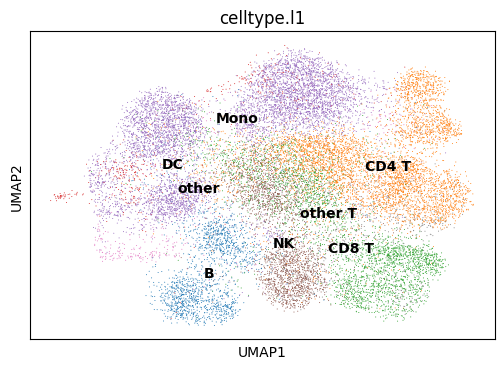

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


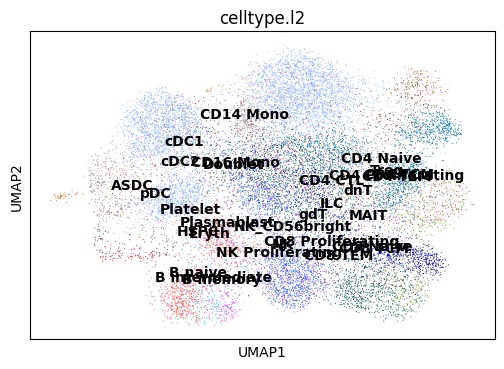

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


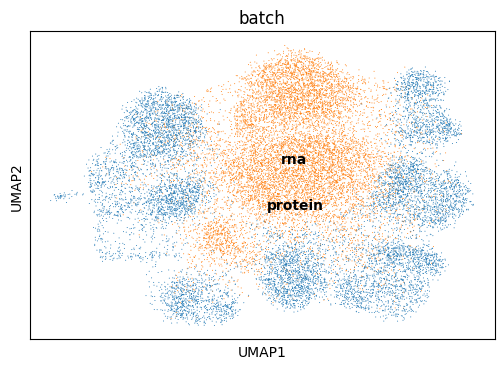

Epoch: 351: 40it [00:01, 20.97it/s]
Epoch: 352: 40it [00:02, 19.62it/s]
Epoch: 353: 40it [00:01, 20.49it/s]
Epoch: 354: 40it [00:01, 20.46it/s]
Epoch: 355: 40it [00:02, 19.14it/s]
Epoch: 356: 40it [00:01, 20.78it/s]
Epoch: 357: 40it [00:01, 20.40it/s]
Epoch: 358: 40it [00:01, 20.82it/s]
Epoch: 359: 40it [00:01, 20.84it/s]
Epoch: 360: 40it [00:01, 21.18it/s]


Losses at epoch: 360 is 3088.0531692504883---------602.8035840988159--------48.47428375482559


Epoch: 361: 40it [00:01, 20.84it/s]
Epoch: 362: 40it [00:01, 20.50it/s]
Epoch: 363: 40it [00:01, 20.89it/s]
Epoch: 364: 40it [00:01, 20.87it/s]
Epoch: 365: 40it [00:02, 19.70it/s]
Epoch: 366: 40it [00:01, 21.11it/s]
Epoch: 367: 40it [00:01, 20.61it/s]
Epoch: 368: 40it [00:01, 20.97it/s]
Epoch: 369: 40it [00:01, 20.71it/s]
Epoch: 370: 40it [00:01, 20.31it/s]
Epoch: 371: 40it [00:01, 21.19it/s]
Epoch: 372: 40it [00:01, 20.13it/s]
Epoch: 373: 40it [00:01, 20.55it/s]
Epoch: 374: 40it [00:01, 21.00it/s]
Epoch: 375: 40it [00:01, 20.09it/s]
Epoch: 376: 40it [00:01, 20.82it/s]
Epoch: 377: 40it [00:01, 20.54it/s]
Epoch: 378: 40it [00:01, 21.04it/s]
Epoch: 379: 40it [00:01, 20.92it/s]
Epoch: 380: 40it [00:02, 19.43it/s]


Losses at epoch: 380 is 3075.7824935913086---------602.8137559890747--------70.32682937383652


Epoch: 381: 40it [00:01, 20.85it/s]
Epoch: 382: 40it [00:01, 20.96it/s]
Epoch: 383: 40it [00:01, 20.61it/s]
Epoch: 384: 40it [00:01, 20.70it/s]
Epoch: 385: 40it [00:01, 20.35it/s]
Epoch: 386: 40it [00:01, 20.97it/s]
Epoch: 387: 40it [00:01, 20.83it/s]
Epoch: 388: 40it [00:01, 20.79it/s]
Epoch: 389: 40it [00:01, 20.76it/s]
Epoch: 390: 40it [00:01, 20.72it/s]
Epoch: 391: 40it [00:01, 21.13it/s]
Epoch: 392: 40it [00:01, 20.83it/s]
Epoch: 393: 40it [00:01, 20.20it/s]
Epoch: 394: 40it [00:01, 20.57it/s]
Epoch: 395: 40it [00:02, 18.70it/s]
Epoch: 396: 40it [00:01, 20.66it/s]
Epoch: 397: 40it [00:01, 20.86it/s]
Epoch: 398: 40it [00:01, 20.55it/s]
Epoch: 399: 40it [00:01, 20.17it/s]


In [20]:
recon_loss_gene_log = []
recon_loss_pro_log = []
kl_div_back_pro_log = []
kl_div_z_log = []
kl_div_l_log = []
for epoch in range(400):
    loss = 0.0
    recon_loss_gene_piter = 0.0
    recon_loss_pro_piter = 0.0
    kl_div_back_pro_piter = 0.0
    kl_div_z_piter = 0.0
    kl_div_l_piter = 0.0
    for batchr,batchp in tqdm(zip(rna_dataloader,protein_dataloader), desc="Epoch: {}".format(epoch)):
        x_shared = batchr["x_shared"]
        y_shared = batchp["y_shared"]
        lmean = batchr["mean"]
        lvar = batchr["var"]
        x_shared = x_shared.to(device)
        y_shared = y_shared.to(device)
        lmean = lmean.to(device)
        lvar = lvar.to(device)
        
        optimizer.zero_grad()
        reconst_loss_gene, reconst_loss_protein, kl_div_z, kl_div_l_gene, kl_div_back_pro, z_gene, z_protein, = model(x=x_shared, y=y_shared, local_l_mean_gene = lmean, local_l_var_gene = lvar)
        loss = torch.mean(reconst_loss_gene) + torch.mean(reconst_loss_protein) + torch.mean(kl_div_z) + torch.mean(kl_div_back_pro) + torch.mean(kl_div_l_gene)
        loss.backward()
        optimizer.step()
        recon_loss_gene_piter += torch.mean(reconst_loss_gene).item()
        recon_loss_pro_piter += torch.mean(reconst_loss_protein).item()
        kl_div_z_piter += torch.mean(kl_div_z).item()
        kl_div_back_pro_piter += torch.mean(kl_div_back_pro).item()
        kl_div_l_piter += torch.mean(kl_div_l_gene).item()
        
    recon_loss_gene_log.append(recon_loss_gene_piter/len(rna_dataloader))
    recon_loss_pro_log.append(recon_loss_pro_piter/len(protein_dataloader))
    kl_div_z_log.append(kl_div_z_piter/len(rna_dataloader))
    kl_div_back_pro_log.append(kl_div_back_pro_piter/len(protein_dataloader))
    kl_div_l_log.append(kl_div_l_piter/len(rna_dataloader))
    
    if epoch%20==0:
        print("Losses at epoch: {} is {}---------{}--------{}".format(epoch,recon_loss_gene_piter,kl_div_z_piter, kl_div_back_pro_piter))
    if epoch%50==0:
        with torch.no_grad():
            shared_rna_data = torch.Tensor(rna_dataset.shared_data)
            shared_pro_data = torch.Tensor(protein_dataset.shared_data)
            labelsl1 = rna_dataset.labels_l1
            labelsl2 = rna_dataset.labels_l2
            shared_tensor_mean = torch.Tensor(rna_dataset.local_mean.reshape(-1,1).expand(10000, 1)).to(device)
            shared_tensor_var = torch.Tensor(rna_dataset.local_var.reshape(-1,1).expand(10000, 1)).to(device)
            _, _, _, _, _, z_gene, z_pro = model(shared_rna_data, shared_pro_data, shared_tensor_mean, shared_tensor_var)
            adata_plot = ad.AnnData(X= np.concatenate([z_gene.numpy(), z_pro.numpy()], axis=0))
            adata_plot.obs['celltype.l1'] = np.concatenate([labelsl1,labels_l1], axis=0)
            adata_plot.obs['celltype.l2'] = np.concatenate([labelsl2,labels_l2], axis=0)
            adata_plot.obs['batch'] = np.concatenate([["rna"]*z_gene.shape[0], ["protein"]*z_pro.shape[0]], axis=0)
            sc.pp.neighbors(adata_plot)
            sc.tl.umap(adata_plot)
            sc.pl.umap(adata_plot, color='celltype.l1', legend_loc='on data', s=2)            
            sc.pl.umap(adata_plot, color='celltype.l2', legend_loc='on data', s=2)
            sc.pl.umap(adata_plot, color='batch', legend_loc='on data', s=2)            